# Generative Adversarial Networks (GANs)
Based on [Goodfellow et al. (2014)](https://arxiv.org/abs/1406.2661) paper.

In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-ug9jp62t
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-ug9jp62t
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=e1ce09e028c3f8a28d1887ca80640668de1b0398061898bd78e3ad5d8e1372ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-s2c8a0kw/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from coutils import fix_random_seed, rel_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
dtype = torch.float
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [ ]:
def show_images(images):
  images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
  sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
  sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

  fig = plt.figure(figsize=(sqrtn, sqrtn))
  gs = gridspec.GridSpec(sqrtn, sqrtn)
  gs.update(wspace=0.05, hspace=0.05)

  for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([sqrtimg,sqrtimg]))
  return 

def count_params(model):
  """Count the number of parameters in the model"""
  param_count = sum([p.numel() for p in model.parameters()])
  return param_count

answers = {}
answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)
answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    N, C, H, W = x.size() # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
  """
  An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
  to produce an output of shape (N, C, H, W).
  """
  def __init__(self, N=-1, C=128, H=7, W=7):
    super(Unflatten, self).__init__()
    self.N = N
    self.C = C
    self.H = H
    self.W = W
  def forward(self, x):
    return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    init.xavier_uniform_(m.weight.data)

## MNIST dataset

download MNIST if not exist


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


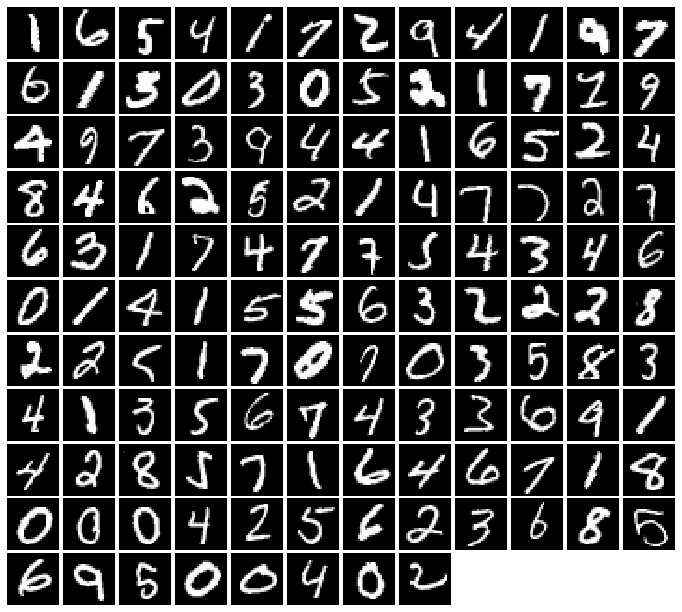

In [ ]:
NOISE_DIM = 96
batch_size = 128

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784)
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [ ]:
def sample_noise(batch_size, dim, dtype=torch.float, device='cpu'):
  """
  Generate a PyTorch Tensor of uniform random noise.

  Input:
  - batch_size: Integer giving the batch size of noise to generate.
  - dim: Integer giving the dimension of noise to generate.
  
  Output:
  - A PyTorch Tensor of shape (batch_size, dim) containing uniform
    random noise in the range (-1, 1).
  """
  ##############################################################################
  # TODO: Implement sample_noise.                                              #
  ##############################################################################
  # Replace "pass" statement with your code
  return torch.rand(batch_size, dim, dtype=dtype, device=device)*2 - 1
  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################

In [ ]:
fix_random_seed(0)

batch_size = 3
dim = 4

z = sample_noise(batch_size, dim)
assert z.shape == (batch_size, dim)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Discriminator
The architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
def discriminator():
  model = nn.Sequential(
    nn.Linear(784, 256, bias=True),
    nn.LeakyReLU(0.01, inplace=True),
    nn.Linear(256, 256, bias=True),
    nn.LeakyReLU(0.01, inplace=True),
    nn.Linear(256, 1, bias=True)
  )
  return model

# Generator
The architecture:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [ ]:
def generator(noise_dim=NOISE_DIM):
  model = nn.Sequential(
    nn.Linear(noise_dim, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 784),
    nn.Tanh()
  )
  return model

# GAN Loss

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated to be *minimizing*.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, `torch.nn.functional.binary_cross_entropy_with_logits` is used to compute these losses. 

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss

In [ ]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.
  
  Inputs:
  - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None
  true_labels = torch.ones(logits_real.size(), requires_grad=True, device=device, dtype=dtype)
  loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, 1 - true_labels)
  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing the (scalar) loss for the generator.
  """
  loss = None
  true_labels = torch.ones(logits_fake.size(), requires_grad=True, device=device, dtype=dtype)
  loss = bce_loss(logits_fake, true_labels)
  return loss

In [ ]:
def get_optimizer(model):
  """
  Construct and return an Adam optimizer for the model with learning rate 1e-3,
  beta1=0.5, and beta2=0.999.
  
  Input:
  - model: A PyTorch model that we want to optimize.
  
  Returns:
  - An Adam optimizer for the model with the desired hyperparameters.
  """
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
  return optimizer

# Training a GAN!

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
  """
  Train a GAN!
  
  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.to(device).reshape(batch_size, -1)
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images)

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images)
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1

Iter: 0, D: 1.371, G:0.6857


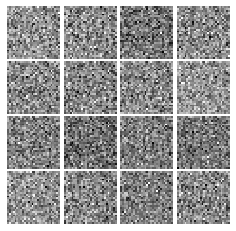


Iter: 250, D: 1.374, G:1.055


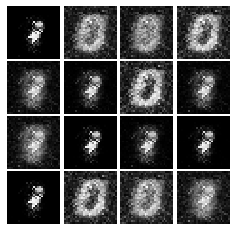


Iter: 500, D: 0.8899, G:1.069


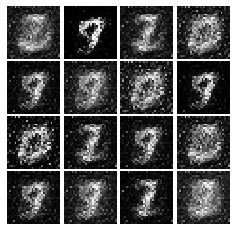


Iter: 750, D: 1.233, G:1.037


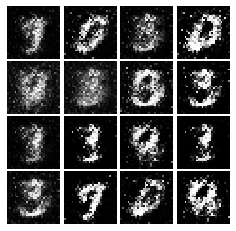


Iter: 1000, D: 1.261, G:1.131


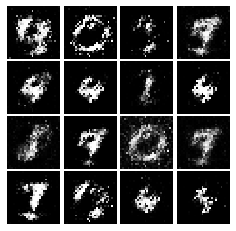


Iter: 1250, D: 1.235, G:0.4486


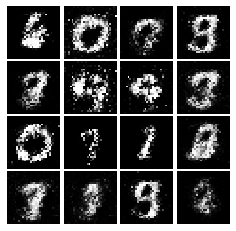


Iter: 1500, D: 1.322, G:0.7296


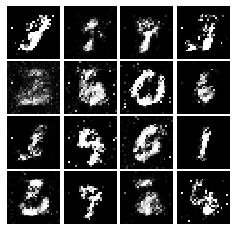


Iter: 1750, D: 1.284, G:1.11


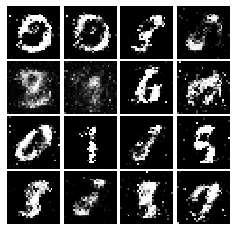


Iter: 2000, D: 1.276, G:1.105


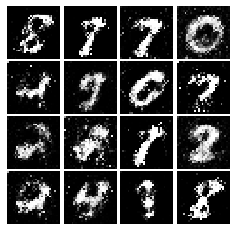


Iter: 2250, D: 1.318, G:1.053


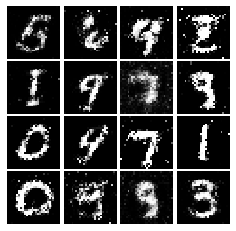


Iter: 2500, D: 1.323, G:0.9203


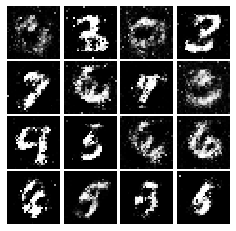


Iter: 2750, D: 1.324, G:0.8647


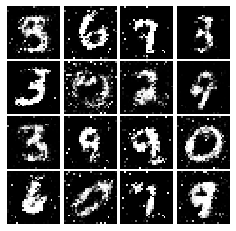


Iter: 3000, D: 1.319, G:0.8515


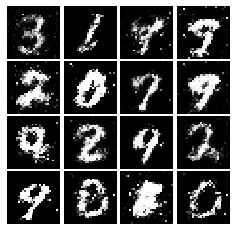


Iter: 3250, D: 1.38, G:0.7882


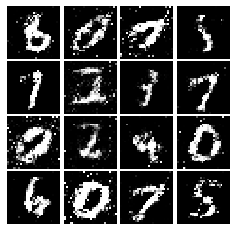


Iter: 3500, D: 1.382, G:0.7744


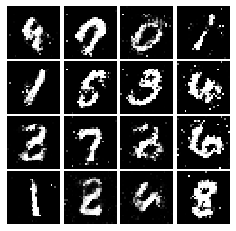


Iter: 3750, D: 1.323, G:0.8169


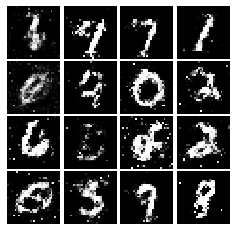


Iter: 4000, D: 1.316, G:0.8438


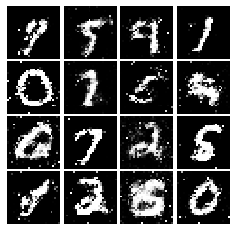


Iter: 4250, D: 1.31, G:0.8981


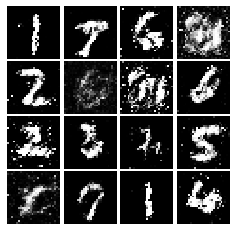


Iter: 4500, D: 1.308, G:0.7562


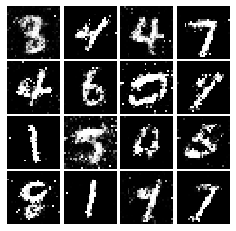

In [ ]:
fix_random_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generator
G = generator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
Based on [Least Squares GAN (Mao et al. 2017)](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. Eq. (9) in paper, the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In these equations, we assume that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
  """
  Compute the Least-Squares GAN loss for the discriminator.
  
  Inputs:
  - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Outputs:
  - loss: A PyTorch Tensor containing the loss.
  """
  true_labels = torch.ones(scores_fake.size(), requires_grad=True, device=device, dtype=dtype)
  loss = (torch.mean((scores_real - true_labels)**2))/2 + (torch.mean((scores_fake)**2))/2
  return loss

def ls_generator_loss(scores_fake):
  """
  Computes the Least-Squares GAN loss for the generator.
  
  Inputs:
  - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Outputs:
  - loss: A PyTorch Tensor containing the loss.
  """
  true_labels = torch.ones(scores_fake.size(), requires_grad=True, device=device, dtype=dtype)
  loss = torch.mean((scores_fake-true_labels)**2)/2
  return loss

Iter: 0, D: 0.442, G:0.4578


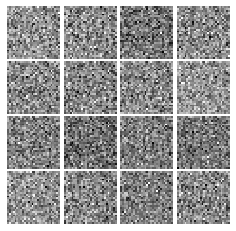


Iter: 250, D: 0.2174, G:0.2435


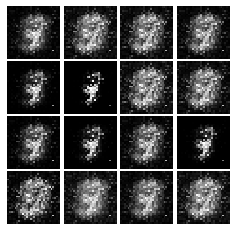


Iter: 500, D: 0.181, G:0.2347


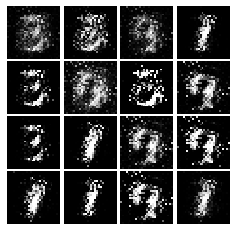


Iter: 750, D: 0.09886, G:0.3088


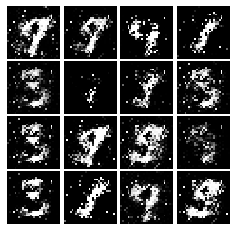


Iter: 1000, D: 0.1829, G:0.206


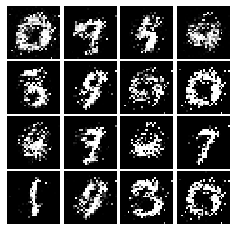


Iter: 1250, D: 0.203, G:0.4473


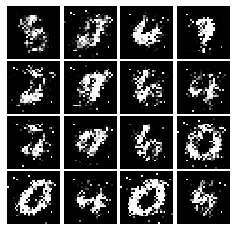


Iter: 1500, D: 0.2218, G:0.2007


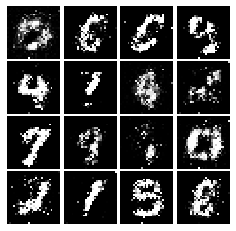


Iter: 1750, D: 0.2402, G:0.1959


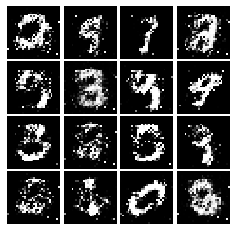


Iter: 2000, D: 0.2141, G:0.1981


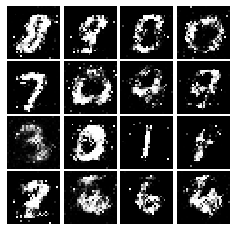


Iter: 2250, D: 0.2222, G:0.1604


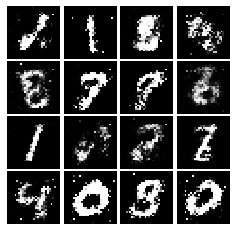


Iter: 2500, D: 0.2468, G:0.1712


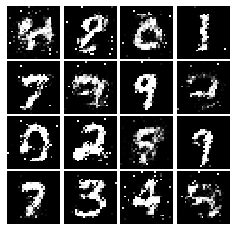


Iter: 2750, D: 0.2231, G:0.1796


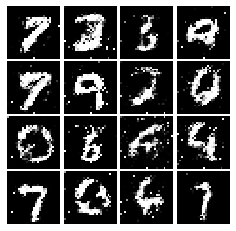


Iter: 3000, D: 0.2143, G:0.1851


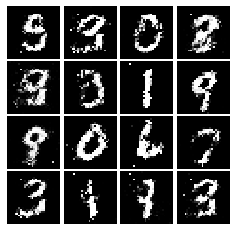


Iter: 3250, D: 0.225, G:0.1667


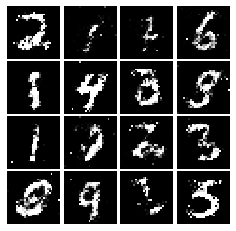


Iter: 3500, D: 0.2399, G:0.1429


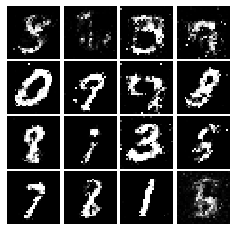


Iter: 3750, D: 0.2293, G:0.1484


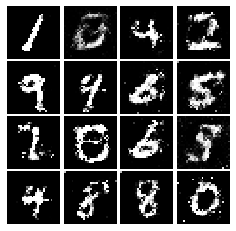


Iter: 4000, D: 0.2276, G:0.1675


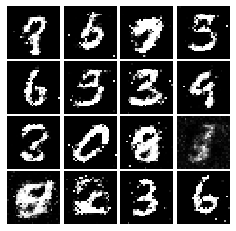


Iter: 4250, D: 0.2312, G:0.1434


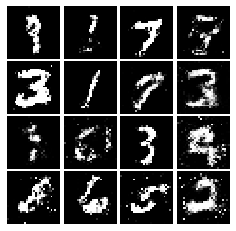


Iter: 4500, D: 0.2409, G:0.1417


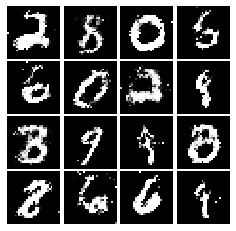

In [ ]:
fix_random_seed(0)

D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# Deeply Convolutional GANs
Based on the ideas from [DCGAN (Radfor et al. 2015)](https://arxiv.org/abs/1511.06434).

#### Discriminator
The architecture
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [ ]:
def build_dc_classifier():
  """
  Build and return a PyTorch model for the DCGAN discriminator implementing
  the architecture above.
  """
  return nn.Sequential(
    nn.Conv2d(1, 32, 5, 1),
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5, 1),
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(4*4*64, 4*4*64),
    nn.LeakyReLU(inplace=True),
    nn.Linear(4*4*64, 1)
  )

data = next(enumerate(loader_train))[-1][0].to(dtype=dtype, device=device)
batch_size = data.size(0)
b = build_dc_classifier().to(device)
out = b(data)
print(out.size())

torch.Size([128, 1])


#### Generator
The architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [ ]:
def build_dc_generator(noise_dim=NOISE_DIM):
  """
  Build and return a PyTorch model implementing the DCGAN generator using
  the architecture described above.
  """
  return nn.Sequential(
    nn.Linear(noise_dim, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 7*7*128),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(7*7*128),
    Unflatten(128, 128, 7, 7),
    nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
    nn.Tanh(),
    Flatten(),
  )

test_g_gan = build_dc_generator().to(device)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, dtype=dtype, device=device)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
  """
  Train a GAN!
  
  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.to(device)
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1

Iter: 0, D: 1.393, G:0.9138


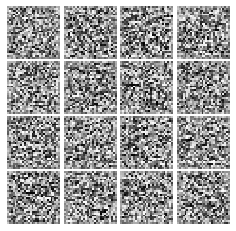


Iter: 250, D: 2.079, G:0.9182


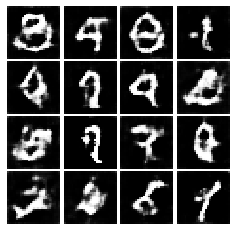


Iter: 500, D: 1.011, G:1.181


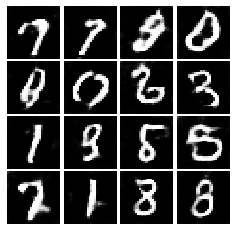


Iter: 750, D: 1.043, G:0.9372


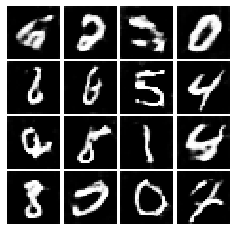


Iter: 1000, D: 1.176, G:0.7524


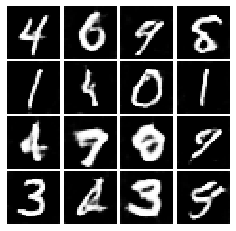


Iter: 1250, D: 1.167, G:0.6792


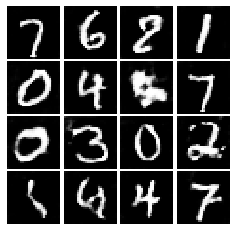


Iter: 1500, D: 1.111, G:1.235


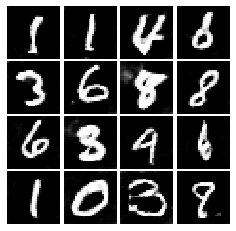


Iter: 1750, D: 1.194, G:1.561


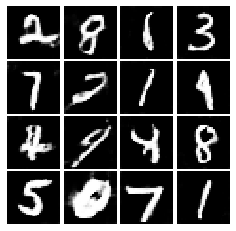


Iter: 2000, D: 1.099, G:1.286


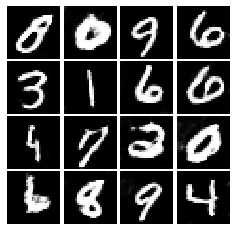


Iter: 2250, D: 1.081, G:1.377


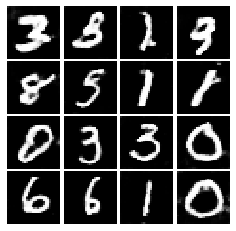

In [ ]:
fix_random_seed(0)

D_DC = build_dc_classifier().to(device) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().to(device)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

#### Latent Space Interpolation
As a final test of our trained GAN model, we can perform interpolation in latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interplate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

torch.Size([144, 96])


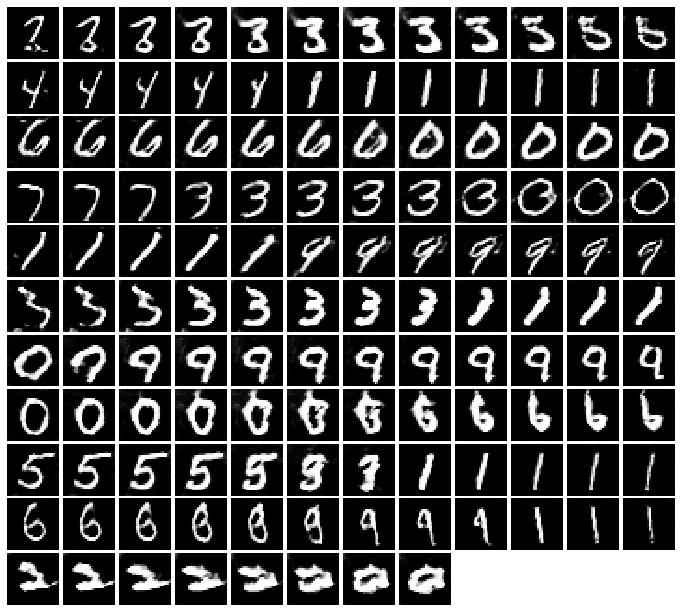

In [ ]:
S = 12
z0 = sample_noise(S, NOISE_DIM, device=device)
z1 = sample_noise(S, NOISE_DIM, device=device)
w = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(S * S, NOISE_DIM)

x = G_DC(z[:128])
show_images(x.data.cpu())